# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 3 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias, Nidham Gazagnadou
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, even non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 17th of february at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "oumaima"
ln1 = "bouther"
fn2 = "ayoub"
ln2 = "tabaai"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_bouther_oumaima_and_tabaai_ayoub.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [3]:
%matplotlib inline

In [4]:
from time import time

import numba
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

In [5]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [6]:
print(numba.__version__) # Your version of Numba

0.51.2


In [7]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
x = x.astype(float)
go_fast(x) # Running a first time the function to compile it

array([[  9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [ 19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.],
       [ 29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.],
       [ 39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.],
       [ 49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.],
       [ 59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.],
       [ 69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.],
       [ 79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.],
       [ 89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.],
       [ 99., 100., 101., 102., 103., 104., 105., 106., 107., 108.]])

In [8]:
np.tanh(0)+ np.tanh(10) + np.tanh(20)

1.9999999958776926

Iteration time of the Numba-compiled function.

In [9]:
%timeit go_fast(x)

The slowest run took 31.17 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 801 ns per loop


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [10]:
%timeit go_fast.py_func(x)

100000 loops, best of 5: 17.6 µs per loop


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For each cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for least-squares regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [11]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [12]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [13]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [14]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [15]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


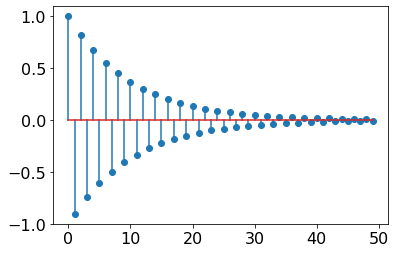

In [16]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [17]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

1.564682552413678e-06

In [18]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.6123904631207887e-07

### Choice of the model

In [19]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [20]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06321512270881251


### Get a very precise minimum to compute distances to minimum

In [21]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad,
                                args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.523330697238848
1.2761345449376552e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [22]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [23]:
# Number of iterations
n_iter = 200

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [24]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    A,b,lbda = args # We can use a if clause to verify if the args length is 3 or not.
    for i in range(n_iter):
        ### TODO
        x -= step*grad(x, A,b,lbda)
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [25]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipschitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [26]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    A,b,lbda = args 
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_new = y - step*grad(x, A,b,lbda)
        t_new = (1 + np.sqrt(1 + 4*t**2))/2
        y = x_new + ((t - 1)/t_new)*(x_new - x)
        x = x_new.copy()
        t = t_new
    return x, x_list

In [27]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s nonlinear conjuguate gradient solver. First, define a function to run scipy algorithms and return the list of iterates.

In [28]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [29]:
# Nonlinear Conjugate gradient algorithm
from scipy.optimize import fmin_cg

x_init = np.zeros(d)

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

         Current function value: 0.523331
         Iterations: 156
         Function evaluations: 289
         Gradient evaluations: 277


### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [30]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [31]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers, xscale='linear', yscale='log'):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")
        plt.yscale(yscale)
        plt.xscale(xscale)

    plt.legend(solvers)

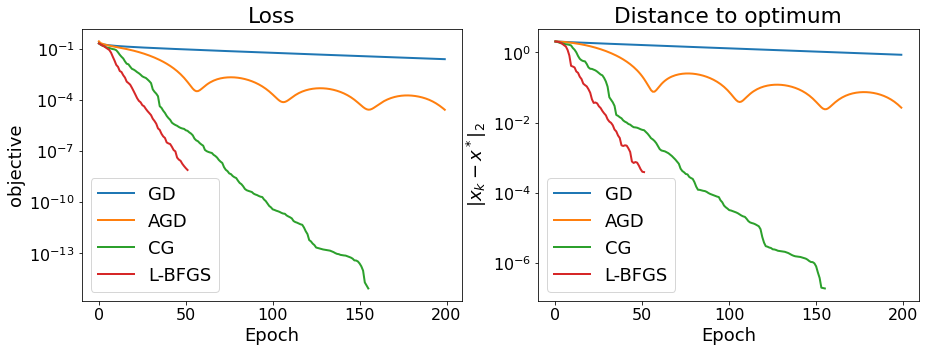

In [32]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]

solvers = ["GD", "AGD", "CG", "L-BFGS"]

plot_epochs(monitors, solvers)

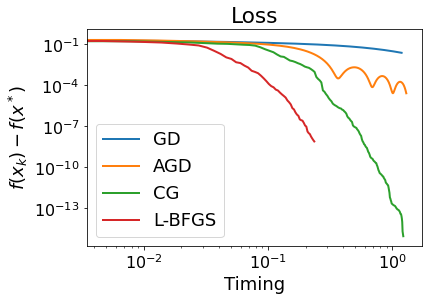

In [33]:
plot_time(monitors, solvers, xscale='log')

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

**Answers**

- **Give some first conclusions about the batch solver studied here**

In terms of convergence performance, the solvers are oredred as follow: **L_BFGS > CG > AGD > GD**  
In terms of convergence speed performance, the solvers are ordered as follow: **GD < AGD < CG < L_BFGS**
So we see that L_BFGS is doing better, in this case, than all the other solvers used. 
- **What do you observe about AGD? is it suprising ?**

This behavior was not surprising, since the FISTA algorithm doesn't guarantee that the loss will always decrease.Instead, FISTA use  weighted memory about the past, that sometimes leads to wrong directions to go which explains why this behaviro of FISTA in this case.

<a id='stoc'></a> 
## 4. Stochastic methods

In [34]:
n_iter = 50

# generate indices of random samples
random_indices = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [35]:
@njit
def sgd(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    A,b,lbda = args
    for idx in range(n_iter):
        i = random_indices[idx]
        ### TODO
        x -= (step/np.sqrt(idx + 1))*grad_i(i,x,A,b,lbda)
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [36]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [37]:
from numpy.core.fromnumeric import mean
@njit
def sag(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    A,b,lbda = args
    for idx in range(n_iter):
        i = random_indices[idx]
        ### TODO
        averaged_gradient += (grad_i(i,x,A,b,lbda) - gradient_memory[i][:]) / n 
        x -= step*averaged_gradient
        gradient_memory[i][:] = grad_i(i,x,A,b,lbda)
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [38]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [39]:
@njit
def svrg(x_init, random_indices, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    A,b,lbda = args
    for idx in range(n_iter):
        
        ### TODO     
        if idx % store_every == 0:
          x_old = x.copy()
          grad_old = grad(x_old, A, b,lbda).copy()
        i = random_indices[idx]
        grad_x = grad_i(i, x, A, b, lbda) - grad_i(i, x_old, A, b, lbda) + grad_old
        x -= step*grad_x

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [40]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

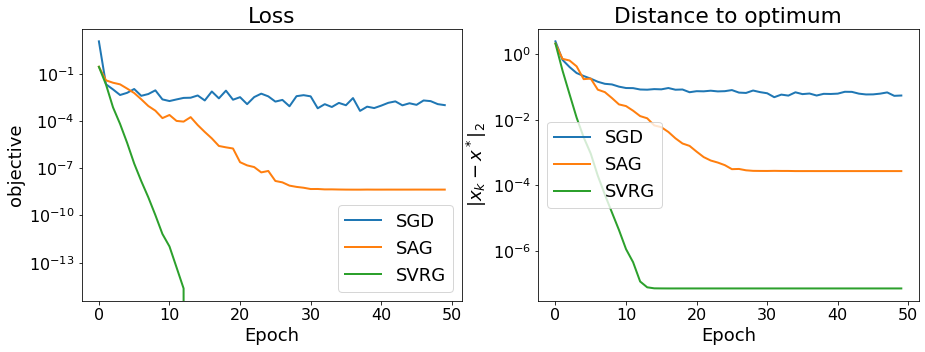

In [41]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

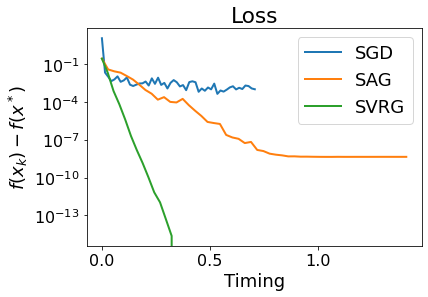

In [42]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

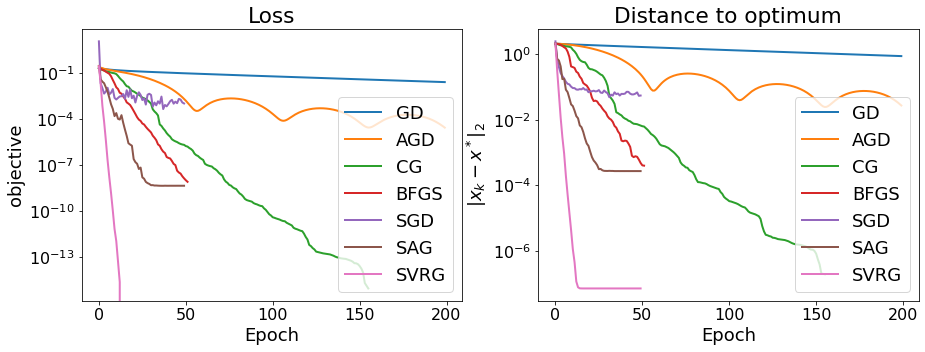

In [43]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

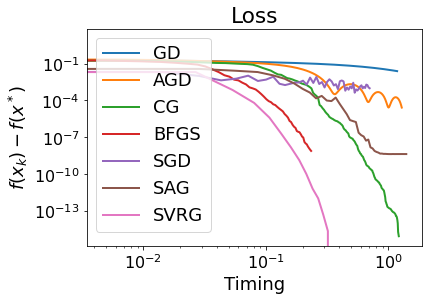

In [44]:
plot_time(monitors, solvers, xscale='log')

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

### Answers

**Question1**

- Compare and comment your results

In terms of convergence performance, the SVRG does better than all the other solvers. This performance could be ordered for all the solvers as follow:**SVGR > SAG > SGD > BFGS > CG > AGD > GD**. SVRG is doing better because of it's variance reduction strategy that allows to the other stochastic solver (like SGD) to attain a linear convergence rate, and avoiding slow-down that hits SGD.

SVRG, unlike SAG, doesn't need to store gradients for each component, but needs to compute two gradients at each iteration, and a full gradient periodically.

**Question2** 

- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1$ and compare your results. Comment.

In [68]:
lbda = 1. / n

step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))


monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

# stochastic methods
step0 = 1e-1
x_init = np.zeros(d)
monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)
x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

         Current function value: 0.498605
         Iterations: 50
         Function evaluations: 82
         Gradient evaluations: 82


The convergence of the objective function with lambda = 1./n


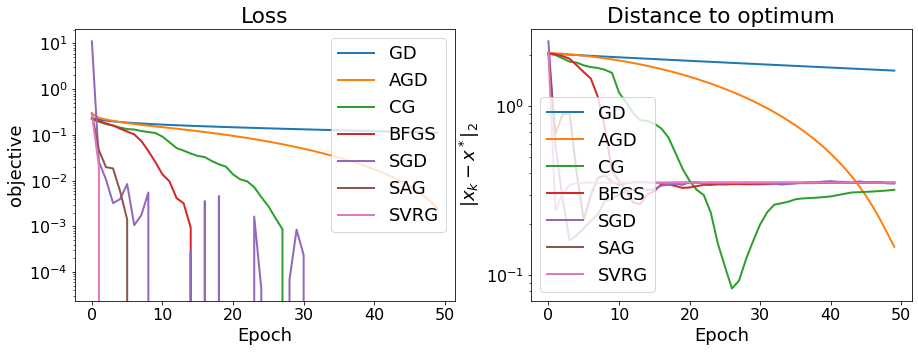

In [69]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

print("The convergence of the objective function with lambda = 1./n",)
plot_epochs(monitors, solvers)

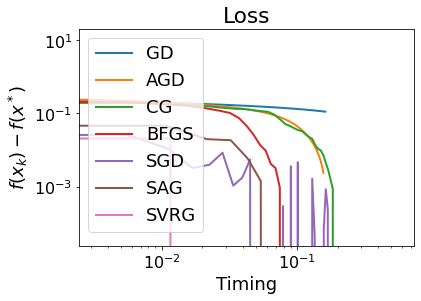

In [70]:
plot_time(monitors, solvers, xscale='log')

In [71]:
lbda = 1.

step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))


monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

# stochastic methods
step0 = 1e-1
x_init = np.zeros(d)
monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)
x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

         Current function value: 0.696724
         Iterations: 17
         Function evaluations: 35
         Gradient evaluations: 34


The convergence of the objective function with lambda = 1


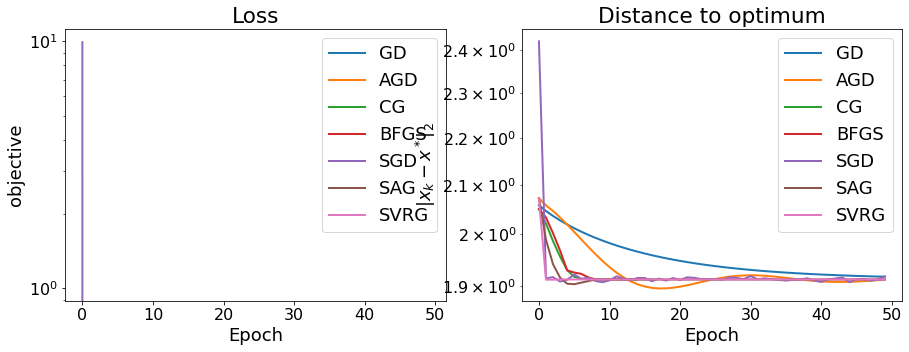

In [72]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

print("The convergence of the objective function with lambda =",1)
plot_epochs(monitors, solvers)

Here, we see the impact of going from a high regularization parameter to low regularization that makes the convergence faster in terms of number of epochs, since the convergence rate is upper bounded by a decreasing function of the regularization which explains why all algorithms converge faster with high regularization. Furthermore, for a low regularization all the algorithms converges with the same speed except CD which is slower than all the others.

Using a regularization that is too high will make the algorithm to minimize the regularization term rather than the objective function we want to minimize which explains the behavior of the algorithms for a high regularization.

**Question3**

- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.

In [84]:
lbda = 1. / n ** (0.5)
high_corr = 0.95
low_corr = 0.5
A_low, b_low = simu_linreg(x_model_truth, n, std=1., corr=low_corr)
A_high, b_high = simu_linreg(x_model_truth, n, std=1., corr=high_corr)

In [82]:
# Low correlation
step = 1. / lipschitz_linreg(A_low, b_low, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A_low, b_low ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A_low, b_low, lbda))

monitor_agd = monitor(agd, loss, x_min, (A_low, b_low,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A_low, b_low, lbda))

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A_low, b_low ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A_low, b_low, lbda), gtol=1e-9)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A_low, b_low,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A_low, b_low, lbda), pgtol=1e-30)

# stochastic methods
step0 = 1e-1
x_init = np.zeros(d)
monitor_sgd = monitor(sgd, loss, x_min, (A_low, b_low,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A_low, b_low, lbda))

max_squared_sum = np.max(np.sum(A_low ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)
x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A_low, b_low ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A_low, b_low, lbda))

x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A_low, b_low ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A_low, b_low, lbda))

         Current function value: 0.532216
         Iterations: 32
         Function evaluations: 111
         Gradient evaluations: 100


The convergence of the objective function with corr = 0.5


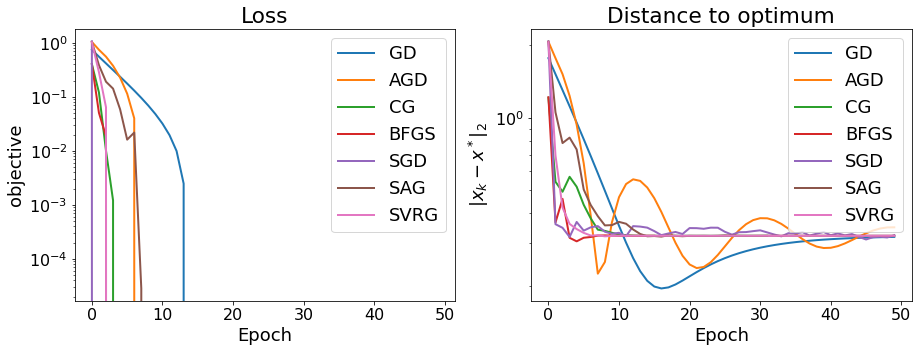

In [83]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

print("The convergence of the objective function with corr =",low_corr)
plot_epochs(monitors, solvers)

In [85]:
# high correlation
step = 1. / lipschitz_linreg(A_high, b_high, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A_high, b_high ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A_high, b_high, lbda))

monitor_agd = monitor(agd, loss, x_min, (A_high, b_high,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A_high, b_high, lbda))

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A_high, b_high ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A_high, b_high, lbda), gtol=1e-9)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A_high, b_high,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A_high, b_high, lbda), pgtol=1e-30)

# stochastic methods
step0 = 1e-1
x_init = np.zeros(d)
monitor_sgd = monitor(sgd, loss, x_min, (A_high, b_high,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A_high, b_high, lbda))

max_squared_sum = np.max(np.sum(A_high ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)
x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A_high, b_high ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A_high, b_high, lbda))

x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A_high, b_high ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter * n, step, args=(A_high, b_high, lbda))

         Current function value: 0.518779
         Iterations: 50
         Function evaluations: 84
         Gradient evaluations: 84


The convergence of the objective function with corr = 0.95


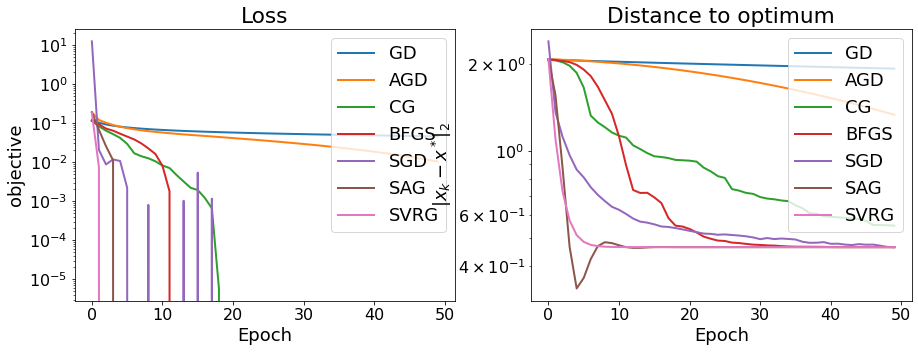

In [87]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

print("The convergence of the objective function with corr =",high_corr)
plot_epochs(monitors, solvers)

First, we see that **AGD** is significantly better than **GD** in high correlation case than low, but both methods converge faster in higher correlation than in the low correlation. But, the **BFGS** has significantly slower convergence rate in high correlation than in low correlation. For those methods, we observe that their complexities is proportional to the correlation factor between the features used.

In the other hand, the stochastic algorithms seems more robust to the correlation between the features.Under high correlation, SGD has slightly slower convergence rate, while SVRG and SAG actually have improved convergence rates.

**Conclusion**

From all what we have see, we can say that SGD is doing a good work if we want to do a one pass or two through the data.But, instead, if we can do many passes, like some hundreds, through the data we can think to use CG, BFGS or SVRG to optimize the objective function, especially if the number of passes through the data is not that high so SVRG would a very good option to do. Indeed, it starts out better than all deterministic methods, with a performance similar to SGD, but the SAG iterations continue to make steady progress even after the first few passes through the data. This leads to better performance than SGD on later iterations.

One other options to use, is to start with SGD,which do a very good performance at the begining and then use SVRG solver, which is similare to the strategy of changing the learning rate but the choise of when to stop SGD and start the other solver we can't now it, but it will do a better performance.